In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import xlwings as xw

# View the current data open in Excel
curr_data = array(xw.Range('A1:B20').value)
curr_data

array([[ 10.  ,   3.39],
       [ 15.  ,   3.54],
       [ 20.  ,   3.34],
       [ 25.  ,   3.07],
       [ 30.  ,   2.79],
       [ 35.  ,   2.47],
       [ 40.  ,   2.13],
       [ 45.  ,   1.82],
       [ 50.  ,   1.66],
       [ 52.  ,   1.67],
       [ 53.  ,   1.7 ],
       [ 54.  ,   1.74],
       [ 55.  ,   1.79],
       [ 56.  ,   1.9 ],
       [ 57.  ,   2.02],
       [ 58.  ,   2.15],
       [ 60.  ,   2.47],
       [ 65.  ,   4.22],
       [ 70.  ,   7.89],
       [ 75.  ,  14.06]])

In [3]:
angle_deg = array(curr_data[:,0])
intensity_mV = array(curr_data[:,1])

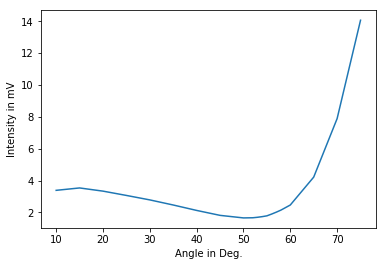

In [4]:
# A quick plot of the data yields
plot(angle_deg, intensity_mV)
xlabel('Angle in Deg.')
ylabel('Intensity in mV')

In [5]:
n_1 = 1

## Gradients and differentiation rules

Note that
$$
\ell \equiv \sqrt{1-\left(\frac{n_1}{n_2}\sin\theta_i\right)^2} = \cos\theta_t
$$
such that
$$
\frac{d\ell}{dn_2} = \frac{n_1 \sin\theta_i}{n_2^3\sqrt{\ell}}
$$

In [6]:
def d_division(u, v, du, dv):
    return (du*v - dv*u)/(v*v)

def d_multiplication(u, v, du, dv):
    return u*dv + du*v

def l_funct(angle_i_rad, n_1, n_2):
    return sqrt(1 - (n_1/n_2*sin(angle_i_rad))**2)

def l_grad(angle_i_rad, n_1, n_2):
    return n_1*sin(angle_i_rad)/(n_2**3 * l_funct(angle_i_rad, n_1, n_2))

In [ ]:
def Rp(angle_i_rad, n_1, n_2):
    l = l_funct(angle_i_rad, n_1, n_2)
    costi = cos(angle_i_rad)
    return ((n_1*l - n_2*costi)/(n_1*l + n_2*costi))**2

def grad_Rp(angle_i_rad, n_1, n_2):
    l = l_funct(angle_i_rad, n_1, n_2)
    dl = l_grad(angle_i_rad, n_1, n_2)
    costi = cos(angle_i_rad)
    u = n_1*l - n_2*costi
    v = n_1*l + n_2*costi
    du = n_1*dl - costi
    dv = n_1*dl + costi
    
    d_div = d_division(u, v, du, dv)
    
    return 2*(n_1*l - n_2*costi)/(n_1*l + n_2*costi)*d_div

def sqrt_likelihood(angle_i_rad, n_1, n_2, coef, intensity_au, alpha=0):
    rp = Rp(angle_i_rad, n_1, n_2)
    return coef*rp - intensity_au - alpha

def likelihood_grad_n2(angle_i_rad, n_1, n_2, coef, intensity_au, alpha=0):
    l = sqrt_likelihood(angle_i_rad, n_1, n_2, coef, intensity_au, alpha)
    d_rp = grad_Rp(angle_i_rad, n_1, n_2)
    return 2*l*d_rp

def likelihood_grad_coef(angle_i_rad, n_1, n_2, coef, intensity_au, alpha=0):
    l = sqrt_likelihood(angle_i_rad, n_1, n_2, coef, intensity_au, alpha)
    rp = Rp(angle_i_rad, n_1, n_2)
    return 2*l*rp

### Simple stochastic gradient descent algorithm
Given $\eta = .005$ the simple update rule is, given the error function (call it $E$) which we seek to minimize dependent on some parameters $\theta$ and set of data points $\{x_i\}$ is
$$
\theta^{i+1} = \theta^{i} - \eta \nabla E(x_i; \theta^{i})
$$
note that the derivatives are computed above.

In [ ]:
n2_init = 1.5
A_init = 20
intercept_init = 0
learning_rate = .005
with_intercept = False

A = A_init
n_2 = n2_init
alpha = intercept_init if with_intercept else 0

N = 100000
N_update = N//30

old_err, new_err = 1e9, 1e9

for i in range(N):
    if i%N_update == 0:
        error = 0
        for angle, I in zip(angle_deg, intensity_mV):
            angle_rad = angle*pi/180
            error += sqrt_likelihood(angle_rad, n_1, n_2, A, I, alpha)**2
        old_err, new_err = new_err, error
        print('Current error : {:.4f}'.format(error))
        err_change = abs(old_err - new_err)
        if err_change < 1e-5:
            print('Error change below threshold (eps = {:.3e}), breaking.'.format(err_change))
            break
    
    for angle, I in zip(angle_deg, intensity_mV):
        angle_rad = angle*pi/180
        n_2_update = learning_rate*likelihood_grad_n2(angle_rad, n_1, n_2, A, I, alpha)
        if with_intercept:
            alpha_update = -2*learning_rate*sqrt_likelihood(angle_rad, n_1, n_2, A, I, alpha)
        A -= learning_rate*likelihood_grad_coef(angle_rad, n_1, n_2, A, I, alpha)
        n_2 -= n_2_update
        if with_intercept: 
            alpha -= alpha_update
        

print('Found A : {:.3f} and n_2 : {:.3f}'.format(A, n_2))

Current error : 283.5563
Current error : 114.8387
Current error : 63.8292
Current error : 47.7065


In [ ]:
rp_out = []
for angle in angle_deg:
    angle_rad = angle*pi/180
    if with_intercept:
        rp_out.append(A*Rp(angle_rad, n_1, n_2) - alpha)
    else:
        rp_out.append(A*Rp(angle_rad, n_1, n_2))
        
material_name = 'Borofloat'
plot(angle_deg, rp_out, label='Fitted curve')
plot(angle_deg, intensity_mV, label='Experimental curve')
title('{} data fitting{}: $n_2 \\approx {:.3f}$'.format(material_name, ' with intercept' if with_intercept else '', n_2))
xlabel(r'Angle of incidence $\theta$')
ylabel(r'Incident intensity (a.u.)')
legend()
savefig('{}_data_fitting{}.png'.format(material_name.lower(), '_intercept' if with_intercept else ''), dpi=600)